In this file we explore all filtering methods as well as scaling techniques.
Everything is done on the training set which includes 58 samples (out of 96)
Filtering is done on the trining split

In [1]:
from methods.feature_selection import *
from methods.helper import *
import seaborn as sns
import random
import math
import warnings
import qnorm
warnings.filterwarnings("ignore")

C:\Users\mjgoj\miniconda3\Lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Load the unscaled data

In [2]:
lipidomics, proteomics, metabolomics = load_data(scaled=False)

In [3]:
# Retrieve the training sets
metabolomics_train, _ = get_train_test_split_dataset(metabolomics)
lipidomics_train, _ = get_train_test_split_dataset(lipidomics)
proteomics_train, _ = get_train_test_split_dataset(proteomics)

Y = metabolomics_train['TwoClass']
# Drop the columns that are not needed
metabolomics_train = metabolomics_train.drop(['ThreeClass', 'RID', 'TwoClass'], axis=1)
lipidomics_train = lipidomics_train.drop(['ThreeClass', 'RID', 'TwoClass'], axis=1)
proteomics_train = proteomics_train.drop(['ThreeClass', 'RID', 'TwoClass'], axis=1)

In [4]:
def plot_initial_distribution(metabolomics_, lipidomics_, proteomics_):
    """
    Plot how much each omics type contributes to the dataset
    :param metabolomics_: The metabolomics dataset
    :param lipidomics_: The lipidomics dataset
    :param proteomics_: The proteomics dataset
    """
    
    print("Total number of samples: ", len(metabolomics_.index))
    
    count = [
        len(metabolomics_.columns), 
        len(lipidomics_.columns), 
        len(proteomics_.columns) ]
    names = ["Metabolomics", "Lipidomics", "Proteomics"]
    data = pd.DataFrame({"Dataset Size": count, "Omics Type": names})
    
    plt.figure(figsize=(7, 4))
    ax = sns.barplot(
        data, 
        x="Dataset Size", y="Omics Type", orient="h",
        palette="husl"
    )
    # Add the count above the bars
    for i in range(len(count)):
        ax.text(count[i], i, count[i], color='black', ha="left")
    plt.title("Contribution of each Omics type to the dataset")

Total number of samples:  58


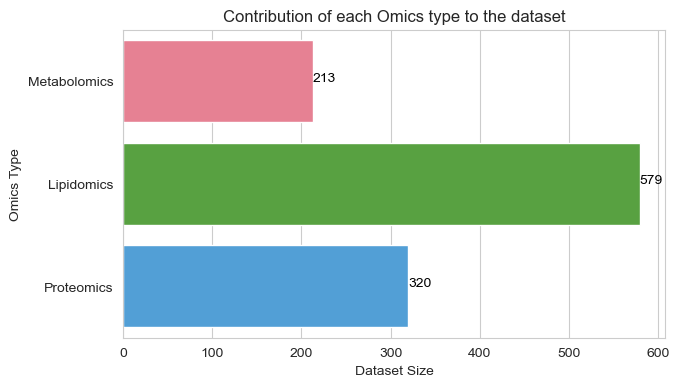

In [5]:
# Plot the distribution of the omics data
plot_initial_distribution(metabolomics_train, lipidomics_train, proteomics_train)

### Feature Selection

In [5]:
def omics_filtering(x, y, title, keep_ratio=0.5):
    """
    Apply all filtering methods to the dataset and plot the Venn Diagram of the results
    :param x: The dataset
    :param y: The labels
    :param title: The title of the plot
    :param keep_ratio: The ratio of features to keep
    """
    
    print("Number of features before filtering: ", len(x.columns))
    
    ANOVA_ = ANOVA_correlation_filtering(x, y, keep_ratio)
    MIFS_ = mutual_information_filtering(x, y, keep_ratio)
    RFE_ = recursive_feature_elimination(x, y, keep_ratio)
    
    venn_diagram(
        [set(ANOVA_), set(MIFS_), set(RFE_)],
        ("ANOVA correlation", "Mutual information", "RFE"),
        title, colors=["#ef767a", "#669ad3", "#52d6bf"], alpha=0.7
    )

Number of features before filtering:  213


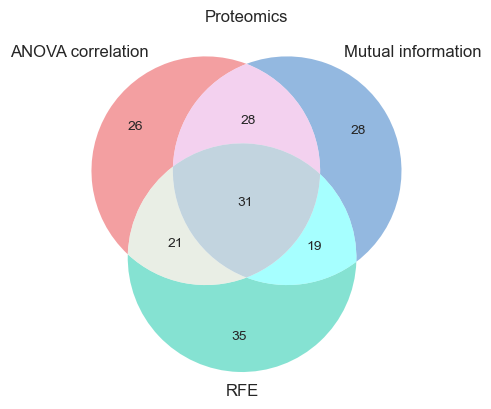

In [6]:
omics_filtering(proteomics_train, Y, "Proteomics")

Number of features before filtering:  579


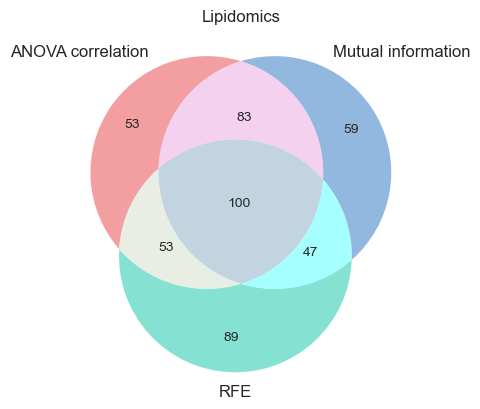

In [7]:
omics_filtering(lipidomics_train, Y, "Lipidomics")

Number of features before filtering:  320


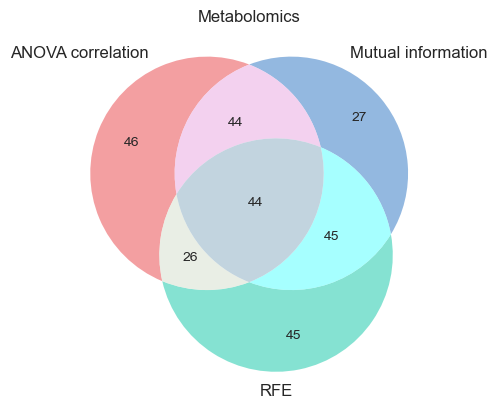

In [8]:
omics_filtering(metabolomics_train, Y, "Metabolomics")

# Boruta Feature Selection

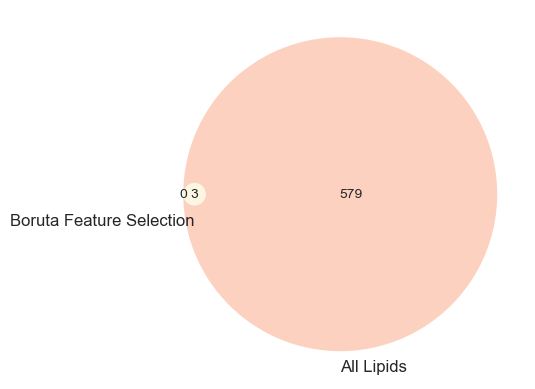

Index(['CE_24_6_', 'GM3_D18_1_24_1_', 'HEXCER_D18_1_24_1_'], dtype='object')


In [14]:
# Lipidomics
boruta_selected_lipids = boruta_filtering(lipidomics_train, Y)
# Plot Venn Diagram
venn_diagram(
    [set(boruta_selected_lipids), set(lipidomics.columns)],
    ["Boruta Feature Selection", "All Lipids"]
)
print(boruta_selected_lipids)

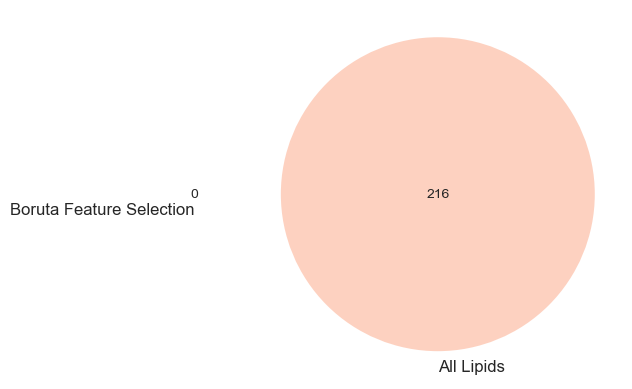

Index([], dtype='object')


In [15]:
# Metabolomics
boruta_selected_metabolites = boruta_filtering(metabolomics_train, Y)
# Plot Venn Diagram
venn_diagram(
    [set(boruta_selected_metabolites), set(metabolomics.columns)],
    ["Boruta Feature Selection", "All Lipids"]
)
print(boruta_selected_metabolites)

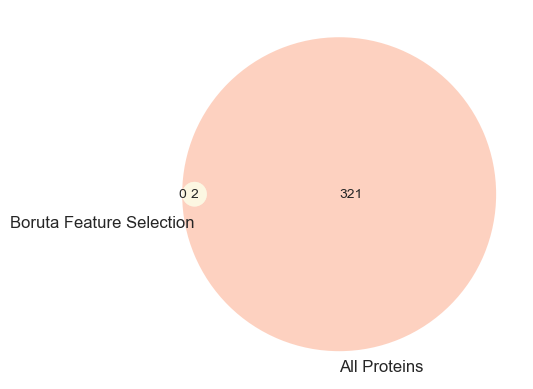

Index(['LGADMEDVR', 'SGETVINTANYHDTSPYR'], dtype='object')


In [16]:
# Proteomics
boruta_selected_proteins = boruta_filtering(proteomics_train, Y)
# Plot Venn Diagram
venn_diagram(
    [set(boruta_selected_proteins), set(proteomics.columns)],
    ["Boruta Feature Selection", "All Proteins"]
)
print(boruta_selected_proteins)

### Normalization of Metabolomics Data

First, we will investigate whether the metabolomics data needs normalization / scaling.

In [17]:
def range_scaling(dataset_):
    """
    https://www.uab.edu/proteomics/metabolomics/workshop/2014/statistical%20analysis.pdf
    Uses min and max values of each feature to scale the data
    Very sensitive to outliers!
    :param dataset_: original non-normalized dataset
    :return: normalized dataset
    """
    for feature in dataset_.columns:
        min_value = dataset_[feature].min()
        max_value = dataset_[feature].max()
        new_column = (dataset_[feature] - min_value) / (max_value - min_value)
        dataset_[feature] = new_column
    return dataset_

def pareto_scaling(dataset_):
    """
    https://www.rdocumentation.org/packages/MetabolAnalyze/versions/1.3.1/topics/scaling
    https://uab.edu/proteomics/metabolomics/workshop/2014/statistical%20analysis.pdf
    Pareto scaling is often used in metabolomics. 
    It scales data by dividing each variable by the square root of the standard deviation,
    so that each variable has variance equal to 1.
    :param dataset_: original non-normalized dataset
    :return: normalized dataset
    """
    for feature in dataset_.columns:
        std = dataset_[feature].std()
        scaling_factor = math.sqrt(std)
        dataset_[feature] = dataset_[feature] / scaling_factor
    return dataset_

In [30]:
def plot_normalization(original_dataset, normalized_dataset, title=None, num_boxes=7): 
    """
    Plot the distribution of the original and normalized data to assess the impact of normalization
    :param original_dataset: The original dataset
    :param normalized_dataset: The normalized dataset
    :param title: The title of the plot
    :param num_boxes: The number of boxes to plot
    """
    # Create box plots to see the distribution of normalized data
    # Find a random subset of features to plot
    random_indices = random.sample(range(len(normalized_dataset.columns)), num_boxes)
    original_dataset = original_dataset.iloc[:, random_indices]
    normalized_dataset = normalized_dataset.iloc[:, random_indices]
    # Find the y-axis limits to have the same scale for both plots
    y_lim_max = max(original_dataset.values.max(), normalized_dataset.values.max())
    y_lim_min = min(original_dataset.values.min(), normalized_dataset.values.min())
    # Add some padding to the y-axis
    y_lim_max += 0.1 * y_lim_max
    y_lim_min -= 0.1 * y_lim_min
    
    
    fig, axes = plt.subplots(2, figsize=(num_boxes, 5))
    colors_ = sns.color_palette("cubehelix", num_boxes)
    sns.boxplot(data=original_dataset, ax=axes[0], palette=colors_, linewidth=.45)
    sns.boxplot(data=normalized_dataset, ax=axes[1], palette=colors_, linewidth=.45)
    axes[0].title.set_text("Original Data")
    axes[0].set_ylim(y_lim_min, y_lim_max)
    axes[1].title.set_text("Normalized Data")
    axes[1].set_ylim(y_lim_min, y_lim_max)
    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    plt.show()

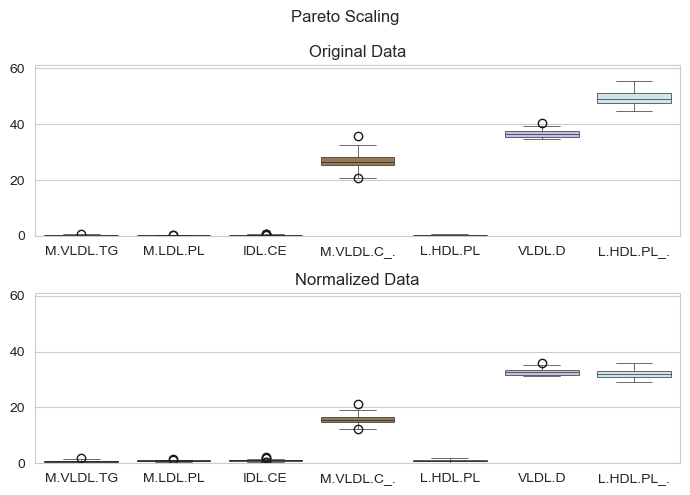

In [31]:
plot_normalization(
    original_dataset=metabolomics_train[metabolomics_train.columns[3:]],
    normalized_dataset=pareto_scaling(metabolomics_train[metabolomics_train.columns[3:]]),
    title="Pareto Scaling",
)

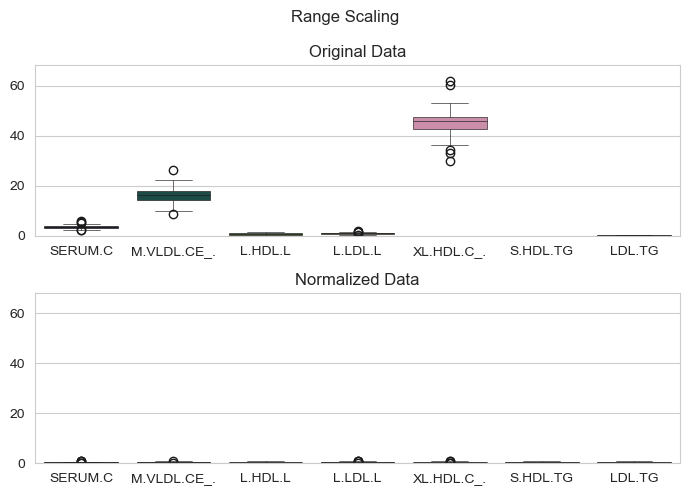

In [32]:
plot_normalization(
    metabolomics_train[metabolomics_train.columns[3:]],
    range_scaling(metabolomics_train[metabolomics_train.columns[3:]]),
    "Range Scaling"
)

Investigating whether Lipidomics and Proteomics data needs normalization / scaling as well based on the histograms of the feature variances.

In [34]:
def plot_feature_variances(dataset_, title, colors, num_bins='auto'):
    """
    For each feature compute the variance and plot a histogram of all the values
    This is needed to assess whether the data needs normalization / scaling
    
    If the histogram shows a wide range of standard deviations, 
    this indicates that features vary greatly in their scale.
    """
    columns_to_drop = ['ThreeClass', 'RID', 'TwoClass']
    if all(column in dataset_.columns for column in columns_to_drop):
        dataset_ = dataset_.drop(['RID', 'ThreeClass', 'TwoClass'], axis=1)
    feature_variances = dataset_.var()
    
    # Create a histogram to see the distribution of variances
    plt.figure(figsize=(6, 3))
    plot = sns.histplot(feature_variances, kde=False, color=colors, bins=num_bins)
    print("Number of bins: ", len(plot.patches))
    plt.title("Histogram of " + title + " Feature Variances")
    plt.xlabel("Feature Variance")
    plt.ylabel("Frequency")
    plt.show()

Number of bins:  96


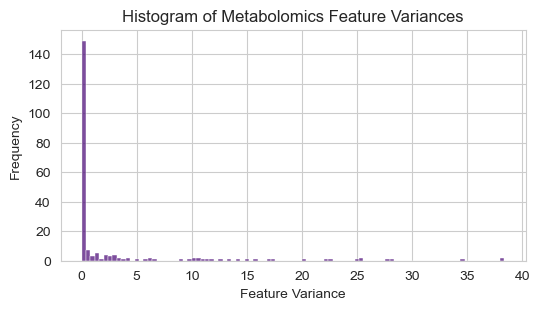

Number of bins:  18


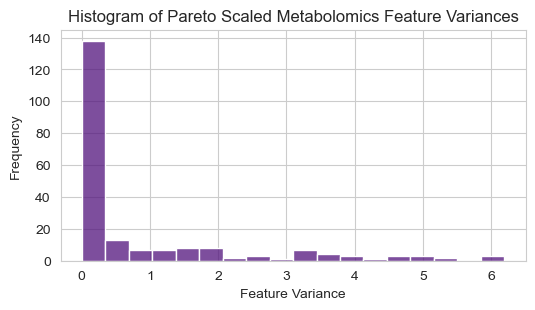

In [35]:
colors_ = sns.color_palette("magma", 3)
plot_feature_variances(
    metabolomics, "Metabolomics", colors_[0])
pareto_scaled_metabolomics = pareto_scaling(metabolomics[metabolomics.columns[3:]])
plot_feature_variances(
    pareto_scaled_metabolomics, "Pareto Scaled Metabolomics", colors_[0])

Number of bins:  36


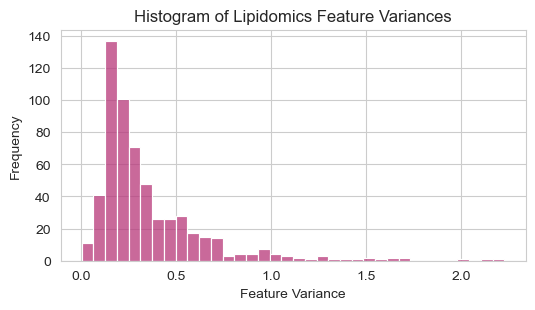

In [36]:
# Valentin already log normalized the lipidomics data
plot_feature_variances(
    lipidomics_train, "Lipidomics", colors_[1])

Number of bins:  150


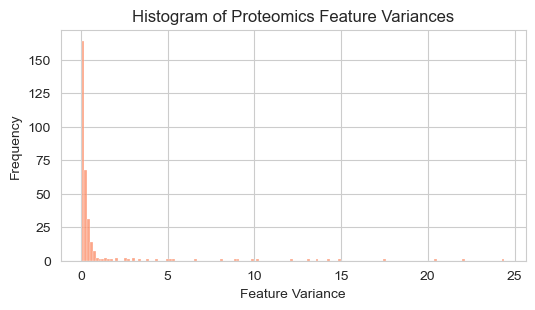

Number of bins:  70


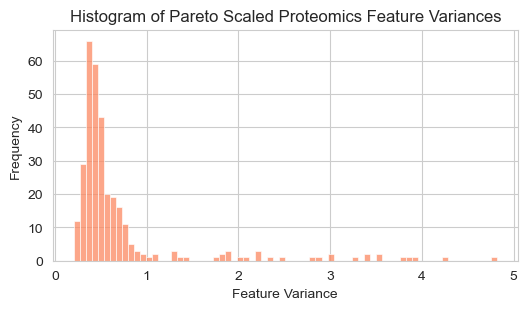

In [40]:
plot_feature_variances(
    proteomics_train, "Proteomics", colors_[2], num_bins=150)
pareto_scaled_proteomics = pareto_scaling(proteomics[proteomics.columns[3:]])
plot_feature_variances(
    pareto_scaled_proteomics, "Pareto Scaled Proteomics", colors_[2], num_bins=70)

Looking at other normalization techniques


In [43]:
def quantile_normalization(dataset_):
    """
    Ensures that the distribution of feature intensities is the same across all samples
    Doesn't seem to be very effective here
    """
    return qnorm.quantile_normalize(dataset_.copy(), axis=1)

def log_transformation(dataset_):
    """
    Log transformation is often used in proteomics
    It stabilizes the variance and reduces the skewness of the data
    """
    return np.log2(dataset_ + 1)

def z_score_normalization(dataset_):
    """
    Standardizes the features based on their mean and standard deviation
    """
    return (dataset_ - dataset_.mean()) / dataset_.std()

Number of bins:  150


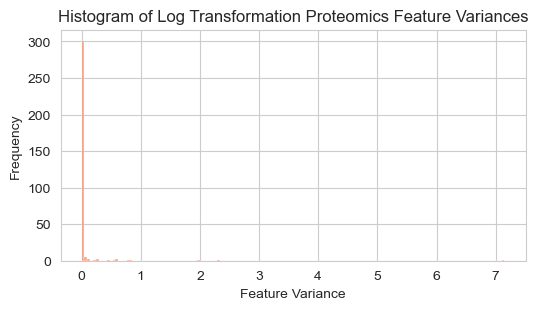

In [44]:
plot_feature_variances(
    log_transformation(proteomics[proteomics.columns[3:]]), 
    "Log Transformation Proteomics", colors_[2], num_bins=150)

Number of bins:  150


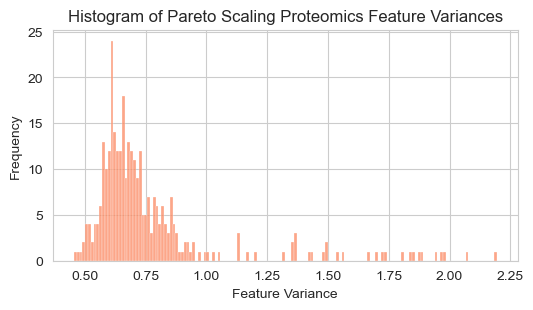

In [45]:
plot_feature_variances(
    pareto_scaling(proteomics[proteomics.columns[3:]]), 
    "Pareto Scaling Proteomics", colors_[2], num_bins=150)

# Saving the datasets
In the end Pareto scaling will be used for the Proteomics and Metabolomics data

In [27]:
path = "C:/Users/mjgoj/Desktop/THESIS/data/final_dataset_split.xls"

pareto_proteomics = pareto_scaling(proteomics[proteomics.columns[3:]])
pareto_proteomics["ThreeClass"] = proteomics["ThreeClass"]
pareto_proteomics["RID"] = proteomics["RID"]
pareto_proteomics["TwoClass"] = proteomics["TwoClass"]
# Move RID, ThreeClass and TwoClass to the first columns
pareto_proteomics = pareto_proteomics[
    ['RID', 'ThreeClass', 'TwoClass'] + [col for col in pareto_proteomics.columns if col not in ['RID', 'ThreeClass', 'TwoClass']]
]

pareto_metabolomics = pareto_scaling(metabolomics[metabolomics.columns[3:]])
pareto_metabolomics["ThreeClass"] = metabolomics["ThreeClass"]
pareto_metabolomics["RID"] = metabolomics["RID"]
pareto_metabolomics["TwoClass"] = metabolomics["TwoClass"]
# Move RID, ThreeClass and TwoClass to the first columns
pareto_metabolomics = pareto_metabolomics[
    ['RID', 'ThreeClass', 'TwoClass'] + [col for col in pareto_metabolomics.columns if col not in ['RID', 'ThreeClass', 'TwoClass']]
]

# Save the datasets in different sheets
with pd.ExcelWriter(path, engine='openpyxl') as writer:
    metabolomics.to_excel(writer, sheet_name='Metabolomics', index=False)
    lipidomics.to_excel(writer, sheet_name='Lipidomics', index=False)
    proteomics.to_excel(writer, sheet_name='Proteomics', index=False)
    pareto_metabolomics.to_excel(writer, sheet_name='Pareto Metabolomics', index=False)
    pareto_proteomics.to_excel(writer, sheet_name='Pareto Proteomics', index=False)    